# ライブラリ

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# warningsを表示しない
import warnings
warnings.filterwarnings("ignore")

# 5.2 回帰不連続デザイン（RDD）

## 5.2.3 メールによる来訪率の増加効果を分析する

In [ ]:
# データ読み込み
email_data = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
email_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [ ]:
# ルールによるメールの配信を行ったログを作成
male_data = email_data.copy()
male_data = male_data[(male_data["segment"] == "No E-Mail") | (male_data["segment"] == "Mens E-Mail")] # segment == Womens E-Mailを落とす
male_data["treatment"] = male_data["segment"].apply(lambda x : 1 if x == "Mens E-Mail" else 0)         # 変数treatment作成
male_data["history_log"] = np.log(male_data["history"])                                                # 変数history_log作成
male_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,5.796301
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,6.514816
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,4.621437
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538


In [ ]:
# 図5.2作成用データ
male_data['history_log_grp'] = np.round(male_data["history_log"] / 0.1) * 0.1
meanvisit = male_data.groupby(["segment", "history_log_grp"]).agg(visit = ("visit", "mean"), N = ("visit", "count")).reset_index()
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,visit,N
0,Mens E-Mail,3.4,0.146545,2750
1,Mens E-Mail,3.5,0.169118,272
2,Mens E-Mail,3.6,0.158576,309
3,Mens E-Mail,3.7,0.131343,335
4,Mens E-Mail,3.8,0.184615,390


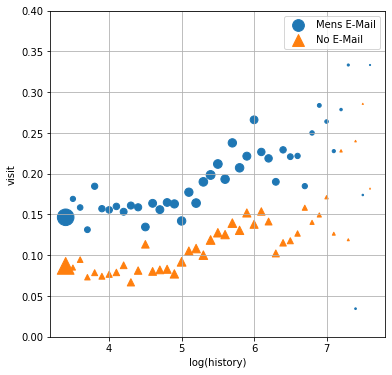

In [ ]:
# 図5.2：実験データにおける来訪率とlog(history_i)
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"], marker = "o", label = "Mens E-Mail", s = meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10)
ax.scatter(meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"], marker = "^", label = "No E-Mail", s = meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc = "best")
ax.grid(True)

In [ ]:
# カットオフ近辺での介入グループと非介入グループの差
meanvisit[(5.0 <= meanvisit["history_log_grp"]) & (meanvisit["history_log_grp"] <= 6.0)].groupby("segment")["visit"].mean()

segment
Mens E-Mail    0.200884
No E-Mail      0.121530
Name: visit, dtype: float64

In [ ]:
# cut-offの値を指定
threshold_value = 5.5

# ルールによる介入を再現したデータの作成
rdd_data = male_data[(
    ((male_data["history_log"] > threshold_value) & (male_data["segment"] == "Mens E-Mail")) | 
    ((male_data["history_log"] <= threshold_value) & (male_data["segment"] == "No E-Mail"))
)]
rdd_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log,history_log_grp
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,6.515942,6.5
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,6.514816,6.5
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538,5.5
15,3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0.0,0,4.062682,4.1
19,5,"6) $750 - $1,000",828.42,1,0,Surburban,1,Multichannel,Mens E-Mail,0,0,0.0,1,6.719520,6.7


In [ ]:
# 図5.3作成用データ
meanvisit = rdd_data.groupby(["segment", "history_log_grp"]).agg(visit = ("visit", "mean"), N = ("visit", "count")).reset_index()
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,visit,N
0,Mens E-Mail,5.5,0.235450,378
1,Mens E-Mail,5.6,0.193277,714
2,Mens E-Mail,5.7,0.237822,698
3,Mens E-Mail,5.8,0.207232,719
4,Mens E-Mail,5.9,0.221519,632


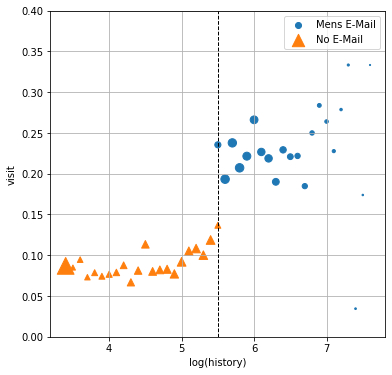

In [ ]:
# 図5.3：非実験データにおける来訪率とlog(history_i)
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"], marker = "o", label = "Mens E-Mail", s = meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10)
ax.scatter(meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"], marker = "^", label = "No E-Mail", s = meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10)
ax.vlines(x = 5.5, ymin = 0, ymax = 0.4, linestyle = "--", linewidth = 1)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc = "best")
ax.grid(True)

### 集計による分析

In [ ]:
# RDDデータでの比較
rdd_data_table = rdd_data.groupby("treatment").agg(count = ("visit", "count"), visit_rate = ("visit", "mean")).reset_index()
print(rdd_data_table)
mean_diff = rdd_data_table["visit_rate"][1] - rdd_data_table["visit_rate"][0]
print(f"\n平均値の差：{mean_diff:.3g}")

   treatment  count  visit_rate
0          0  13926    0.090694
1          1   7366    0.224002

平均値の差：0.133


### 線形回帰による分析

In [ ]:
Y = rdd_data["visit"]
X = sm.add_constant(rdd_data[["treatment", "history_log"]])

rdd_lm_reg = sm.OLS(Y, X).fit()
coef = rdd_lm_reg.summary().tables[1]
coef = pd.read_html(coef.as_html(), header = 0, index_col = 0)[0]
pd.DataFrame(coef.loc["treatment"]).T

,coef,std err,t,P>|t|,[0.025,0.975]
treatment,0.1137,0.008,14.24,0.0,0.098,0.129


### 線形回帰による分析：結果の可視化

In [ ]:
# 図作成用データ
rdd_data["lm_pred"] = rdd_lm_reg.predict(X)
meanvisit = rdd_data.groupby(["segment", "history_log_grp"]).agg(N = ("visit", "count"), visit = ("visit", "mean"), lm_pred = ("lm_pred", "mean")).reset_index()
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,N,visit,lm_pred
0,Mens E-Mail,5.5,378,0.235450,0.217221
1,Mens E-Mail,5.6,714,0.193277,0.218036
2,Mens E-Mail,5.7,698,0.237822,0.219198
3,Mens E-Mail,5.8,719,0.207232,0.220346
4,Mens E-Mail,5.9,632,0.221519,0.221474


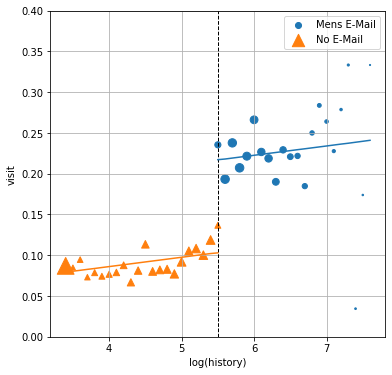

In [ ]:
# 描画
fig, ax = plt.subplots(figsize = (6, 6))

# 散布図
ax.scatter(meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"], marker = "o", label = "Mens E-Mail", s = meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10)
ax.scatter(meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"], marker = "^", label = "No E-Mail", s = meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10)

# 回帰直線
ax.plot(meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "Mens E-Mail"]["lm_pred"]) # カットオフ値以上
ax.plot(meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "No E-Mail"]["lm_pred"])     # カットオフ値未満

# その他
ax.vlines(x = 5.5, ymin = 0, ymax = 0.4, linestyle = "--", linewidth = 1)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc = "best")
ax.grid(True)

### 線形回帰による分析：カットオフ値前後でデータを分けて各々線形回帰

In [ ]:
# データを分割
rdd_data_l = rdd_data[rdd_data["history_log"] < threshold_value].copy()  # カットオフ値未満
rdd_data_r = rdd_data[rdd_data["history_log"] >= threshold_value].copy() # カットオフ値以上

# 分割したデータごとに回帰

# カットオフ値未満
Y_l = rdd_data_l["visit"]
X_l = sm.add_constant(rdd_data_l["history_log"])
reg_l = sm.OLS(Y_l, X_l).fit()

# カットオフ値以上
Y_r = rdd_data_r["visit"]
X_r = sm.add_constant(rdd_data_r["history_log"])
reg_r = sm.OLS(Y_r, X_r).fit()

# カットオフ値における予測値の差
print((reg_r.params[0] + reg_r.params[1] * 5.5) - (reg_l.params[0] + reg_l.params[1] * 5.5))

0.11359235208736707


### 非線形回帰による分析：カットオフ値前後で分けて各々非線形回帰

In [ ]:
# 変数作成
rdd_data["history_log2"] = rdd_data["history_log"] ** 2
rdd_data["history_log3"] = rdd_data["history_log"] ** 3
rdd_data["history_log4"] = rdd_data["history_log"] ** 4

# データを分割
rdd_data_l = rdd_data[rdd_data["history_log"] < threshold_value].copy()  # カットオフ値未満
rdd_data_r = rdd_data[rdd_data["history_log"] >= threshold_value].copy() # カットオフ値以上

# 分割したデータごとに回帰

# カットオフ値未満
Y_l = rdd_data_l["visit"]
X_l = sm.add_constant(rdd_data_l[["history_log", "history_log2", "history_log3", "history_log4"]])
reg_l = sm.OLS(Y_l, X_l).fit()
rdd_data_l["pred"] = reg_l.predict(X_l)

# カットオフ値以上
Y_r = rdd_data_r["visit"]
X_r = sm.add_constant(rdd_data_r[["history_log", "history_log2", "history_log3", "history_log4"]])
reg_r = sm.OLS(Y_r, X_r).fit()
rdd_data_r["pred"] = reg_r.predict(X_r)

# カットオフ値における予測値の差
print((reg_r.params[0] + reg_r.params[1] * 5.5 + reg_r.params[2] * (5.5 ** 2) + reg_r.params[3] * (5.5 ** 3) + reg_r.params[4] * (5.5 ** 4)) - (reg_l.params[0] + reg_l.params[1] * 5.5 + reg_l.params[2] * (5.5 ** 2) + reg_l.params[3] * (5.5 ** 3) + reg_l.params[4] * (5.5 ** 4)))

0.07407940918111677


### 非線形回帰による分析：結果の可視化

In [ ]:
rdd_data_lr.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log,history_log_grp,history_log2,history_log3,history_log4,pred
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,5.486538,5.5,30.102101,165.156325,906.136480,0.130720
15,3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0.0,0,4.062682,4.1,16.505384,67.056125,272.427703,0.080307
20,9,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0.0,0,3.400864,3.4,11.565876,39.333971,133.769485,0.087529
23,2,1) $0 - $100,29.99,0,1,Urban,1,Phone,No E-Mail,0,0,0.0,0,3.400864,3.4,11.565876,39.333971,133.769485,0.087529
24,4,1) $0 - $100,78.24,1,0,Surburban,0,Web,No E-Mail,0,0,0.0,0,4.359781,4.4,19.007691,82.869369,361.292302,0.082828


In [ ]:
# 図作成用データ
rdd_data_lr = pd.concat([rdd_data_l, rdd_data_r], axis = 0)
meanvisit = rdd_data_lr.groupby(["segment", "history_log_grp"]).agg(N = ("visit", "count"), visit = ("visit", "mean"), pred = ("pred", "mean")).reset_index()
meanvisit = meanvisit[meanvisit["N"] > 10]
meanvisit.head()

,segment,history_log_grp,N,visit,pred
0,Mens E-Mail,5.5,378,0.235450,0.209574
1,Mens E-Mail,5.6,714,0.193277,0.215743
2,Mens E-Mail,5.7,698,0.237822,0.221816
3,Mens E-Mail,5.8,719,0.207232,0.225157
4,Mens E-Mail,5.9,632,0.221519,0.226491


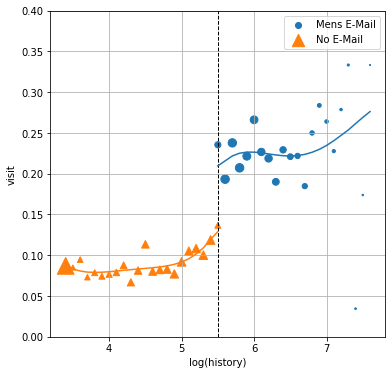

In [ ]:
# 描画
fig, ax = plt.subplots(figsize = (6, 6))

# 散布図
ax.scatter(meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "Mens E-Mail"]["visit"], marker = "o", label = "Mens E-Mail", s = meanvisit[meanvisit["segment"] == "Mens E-Mail"]["N"] / 10)
ax.scatter(meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "No E-Mail"]["visit"], marker = "^", label = "No E-Mail", s = meanvisit[meanvisit["segment"] == "No E-Mail"]["N"] / 10)

# 回帰直線
ax.plot(meanvisit[meanvisit["segment"] == "Mens E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "Mens E-Mail"]["pred"]) # カットオフ値以上
ax.plot(meanvisit[meanvisit["segment"] == "No E-Mail"]["history_log_grp"], meanvisit[meanvisit["segment"] == "No E-Mail"]["pred"])     # カットオフ値未満

# その他
ax.vlines(x = 5.5, ymin = 0, ymax = 0.4, linestyle = "--", linewidth = 1)
ax.set_xlabel("log(history)")
ax.set_ylabel("visit")
ax.set_ylim(0, 0.4)
ax.legend(loc = "best")
ax.grid(True)

# 5.3 nonparametric RDD

